In [2]:
import pandas as pd
import numpy as np
import scipy
import scipy.io
import os
import mat4py
import matplotlib.pyplot as plt
from tabula import read_pdf
import data_describe as dd
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score 
from sklearn.svm import SVC


plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
# Data Intake
def data_intake(matlab_file_path):
    
    """
    This function is to read the data from the matlab file and convert into dataframe for pre-processing
    
    Input - Matlab file
    
    Output - Uncleaned Dataframe resulted from reading the matlab file
    """

    data_dict = scipy.io.loadmat(matlab_file_path)
    data_array = data_dict[list(data_dict.keys())[3]]
    data = pd.DataFrame(data_array.flatten())
    
    return data
    

In [4]:
# Cleaning the dataframe and flattening the Columns for further analysis.

def data_flatten(data):
    
    """
    This function is to clean the dataframe and flatten the relevant columns for further Analysis
    
    Input - Resulted dataframe from reading the matlab file
    
    Output - Cleaned dataframe after flattening the values and filtering the relevant values from the dataframe 
    """
    
    for i in range(0,len(data.columns)):
        if (len(data[data.columns[i]][0].flatten()) == 0):
            continue
        elif (len(data[data.columns[i]][0].flatten()) == 1):
            data[data.columns[i]] = data[data.columns[i]].apply(lambda x: x.flatten()[0]) 
        elif (len(data[data.columns[i]][0].flatten()) > 1):
            data[data.columns[i]] = data[data.columns[i]].apply(lambda x: x.flatten()) 
            
    return data

In [5]:
# Merging the relevant data from the matlab files to form a holistic dataframe for further analysis.

def data_merge(data): 
    
    """
    This function is to merge the cleaned dataframe and form the consolidated dataframe for further analysis
    
    Input - Cleaned Dataframe after the processing the matlab file
            (Resulted dataframe from the data_flatten function) 
            
    Output - Merged final dataframe after removing the null columns  
    """
    
    data_x = pd.DataFrame(data['X'][0].flatten())
    data_x = data_flatten(data_x)

    data_y = pd.DataFrame(data['Y'][0].flatten())
    data_y = data_flatten(data_y)

    final = data_x[['Raster','Data']].merge(data_y[data_y.columns.difference(['Unit',
                                                                              'Description',
                                                                              'DisplayIdentifier']
                                                                              ,sort=False)]
                                            , on = 'Raster', how = 'left')
    
    return final

In [6]:
#Separating the main metrics and additional metrics into different tables for further analysis

def main_sensor_metrics(data):
    """
    This function is to create a new dataframe with the vibrations and current signals for further analysis
    
    Input - Merged final dataframe with the all relevant values from the matlab files
            (Resulted dataframe from the data_merge function) 
            
    Output -  Dataframe with vibrations and Current signals alone
    """
    
    sensor_metrics = pd.DataFrame(list(zip(data['Data_y'][3],
                                    data['Data_y'][4],
                                    data['Data_y'][5])),
                           columns = list(data['Name'][3:6]))
    
    return sensor_metrics

def add_sensor_metrics(data):
    
    """
    This function is to create a new dataframe with all supportive machine signals for further analysis
    
    Input - Merged final dataframe with the all relevant values from the matlab files
            (Resulted dataframe from the data_merge function) 
            
    Output -  Dataframe with all the additional mertrics for the further analysis
    """
    
    add_metric = pd.DataFrame(list(zip(data['Data_y'][0], 
                                       data['Data_y'][1],
                                       data['Data_y'][2])),
                              columns = list(final['Name'][0:3]))
    
    return add_metric

### Extracting Bearing Informations from pdf

In [ ]:
file_pdf = read_pdf(pdf_file_path, pages = 'all', java_options="-Dfile.encoding=UTF8")

for i in range(0, len(file_pdf)):
    if i == 0:
        bearing_specs = file_pdf[0]
    elif i == 1:
        damage_specs = file_pdf[1] 

In [7]:
def bearing_specifications(bearing_specs):
    
    """
    This function is to clean the resulted dataframe from reading the pdf using tabula 
    and create a new dataframe for the specifications
    
    Input - Uncleaned Dataframe with the details about specifications of the bearing used in experiment,
    extracted from the first page of the pdf.
    
    Output - Dataframe with cleaned specifications and values.
    """
    
    temp = pd.DataFrame(index=bearing_specs.index, columns={'specification','value'})
    for i in range(0,len(bearing_specs)):
        if pd.isnull(bearing_specs['Category'][i]):
            temp['specification'][i] = bearing_specs['tion\rSpecification/Value'][i]
            temp['value'][i] = bearing_specs['Unnamed: 1'][i]        
        else:
            temp['specification'][i] = bearing_specs['Category'][i]
            temp['value'][i] = bearing_specs['Unit oper'][i] 

    temp = temp[(temp['specification'] != '-')].reset_index()
    del(temp['index'])
    
    return temp

### EDA using data-describe

In [8]:
# Creating DataFrame for the further Analysis

def eda_metrics_data(matlab_file_path):
    """
    This function is to create a dataframe for the EDA from reading the matlab files 
    using the above defined functions  
    
    Input -  Matlab file path 
    
    Output - Dataframe with vibrations and current signals for Analysis.
    
    """
    uncleaned_data = data_intake(matlab_file_path)
    cleaned_data = data_flatten(uncleaned_data)
    consolidated_cleaned_data = data_merge(cleaned_data)
    metrics_data = main_sensor_metrics(consolidated_cleaned_data)
    
    return metrics_data

In [9]:
# File used for sample visualization - N09_M07_F10_K002_1.mat

metrics_data = eda_metrics_data(matlab_file_path) 

In [10]:
# Summary of the data using data-describe package

dd.data_summary(metrics_data)

,Info
Rows,256001
Columns,3
Size in Memory,5.9 MB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
phase_current_1,float64,0,0,-3,-0,2.97,-0,1.76,7882,154
phase_current_2,float64,0,0,-3,-0,2.95,-0,1.78,8037,148
vibration_1,float64,0,0,-5,-0,4.047,-0,0.18,1297,5278


None

data-describe Summary Widget

<AxesSubplot:title={'center':'Correlation Matrix'}>

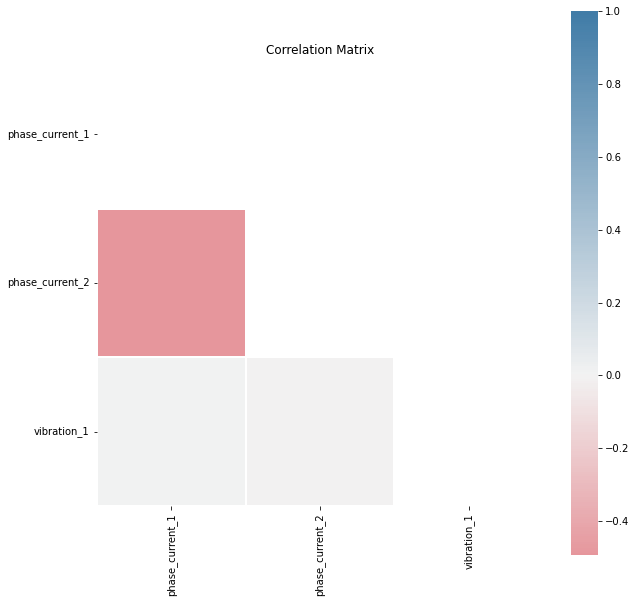

In [11]:
# Correlation matrix of the data using data-describe package

dd.correlation_matrix(metrics_data)

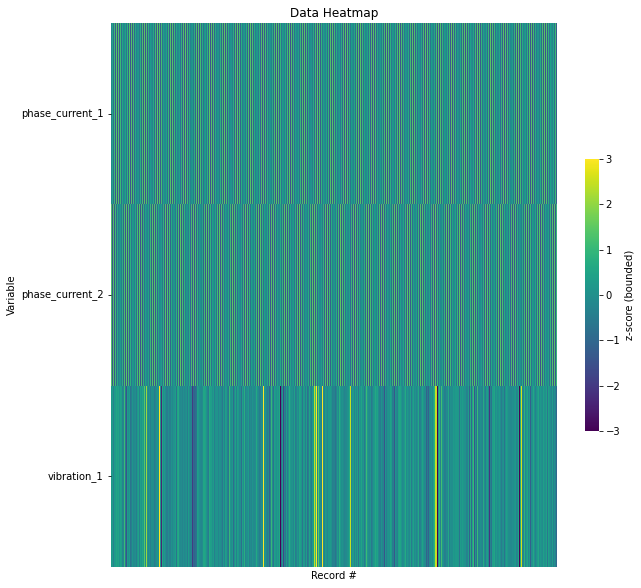

Heatmap Widget showing standardized values.

In [12]:
# Heatmap  

dd.data_heatmap(metrics_data)

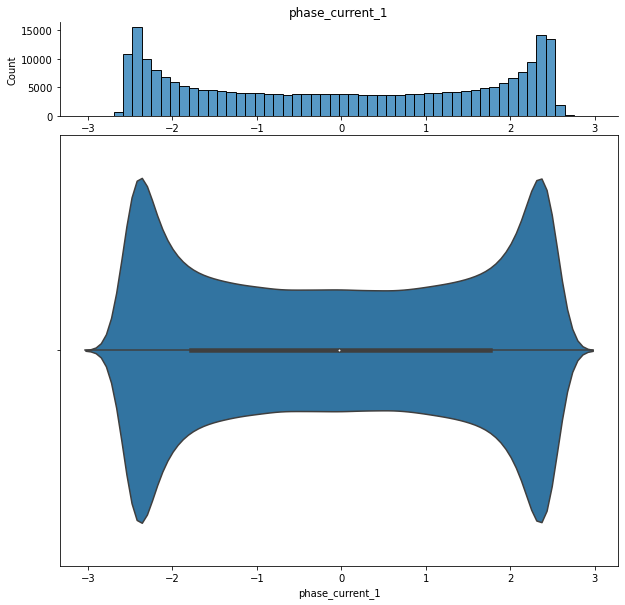

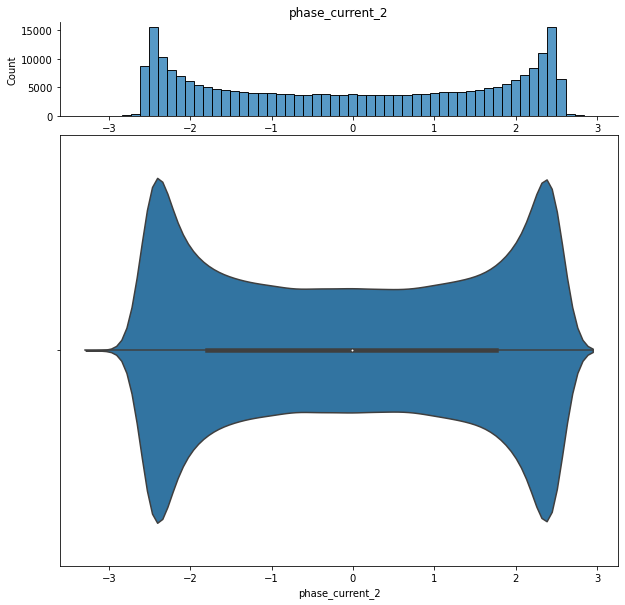

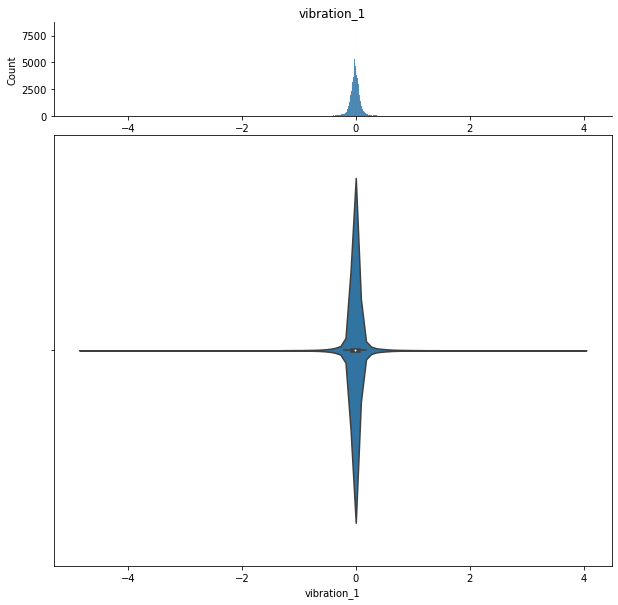

In [13]:
# Distribution of the experiment metrics

for col in metrics_data.columns:
    display(dd.distribution(metrics_data, plot_all=True).plot_distribution(col))

data-describe Scatter Plot Widget

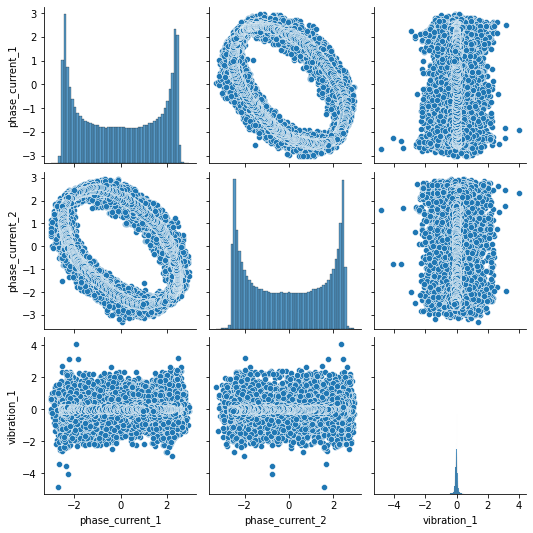

In [14]:
# Scatter plot of all variable

dd.scatter_plots(metrics_data, plot_mode='matrix')

### EDA - (Healthy vs IRD vs ORD)

The sample visualizations in this notebook are plotted using the below matlab files

1. Healthy Bearing : N09_M07_F10_K002_1.mat
2. Inner Ring Damage Bearing : N09_M07_F10_KI01_1.mat
3. Outer Ring Damage Bearing : N09_M07_F10_KA01_1.mat


In [49]:
healthy_data  =  eda_metrics_data('your_healthy_bearing_matlab_file_path')
ird_data  =  eda_metrics_data('your_inner_ring_damage_bearing_matlab_file_path')
ord_data  =  eda_metrics_data('your_inner_ring_damage_bearing_matlab_file_path')

In [50]:
healthy_data = healthy_data.rename(columns = {'vibration_1':'healthy_vibrations'})
ird_data = ird_data.rename(columns = {'vibration_1':'ird_vibrations'})
ord_data = ord_data.rename(columns = {'vibration_1':'ord_vibrations'})

<AxesSubplot:>

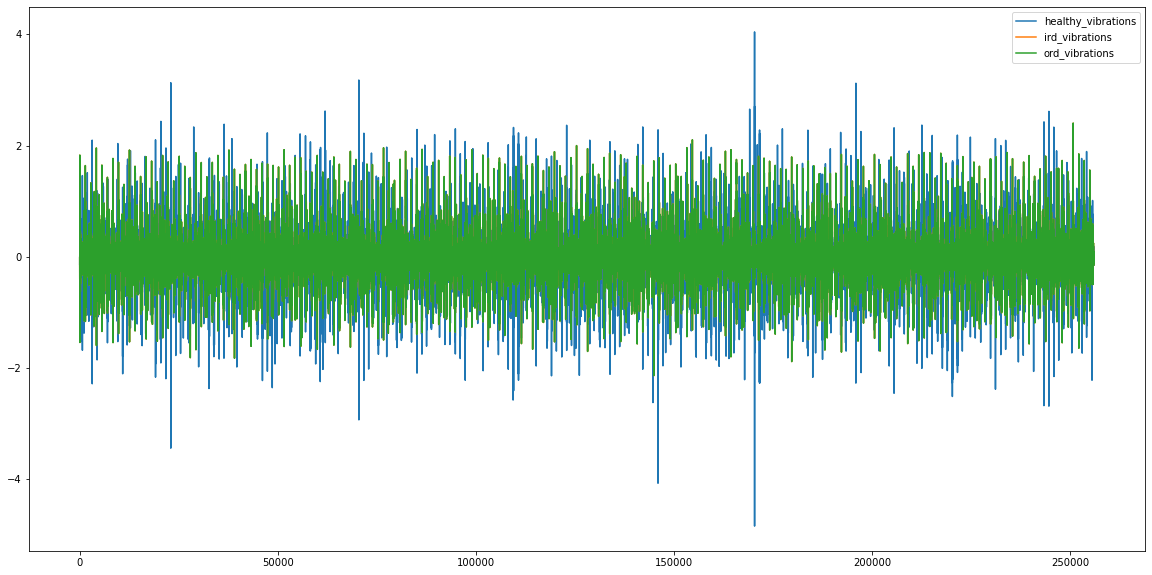

In [51]:
vibrations_data = pd.concat([healthy_data['healthy_vibrations'],ird_data['ird_vibrations'],ord_data['ord_vibrations']], axis = 1)
vibrations_data.plot()

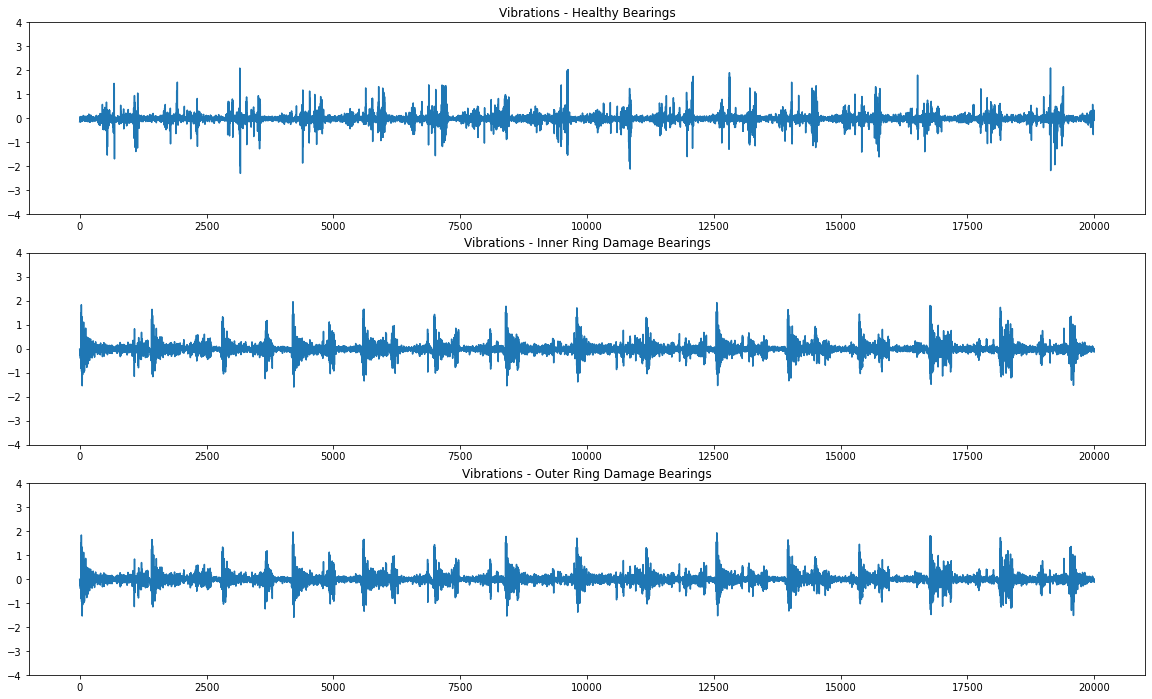

In [52]:
# Plotting the sample vibrations for comparing the Healthy, Inner ring damaged and Outer ring damaged Bearings.

fig, axs = plt.subplots(3, figsize=(20, 12))
plt.setp(axs, ylim=(-4,4))
axs[0].plot(vibrations_data['healthy_vibrations'][0:20000])
axs[1].plot(vibrations_data['ird_vibrations'][0:20000])
axs[2].plot(vibrations_data['ord_vibrations'][0:20000])
axs[0].title.set_text('Vibrations - Healthy Bearings')
axs[1].title.set_text('Vibrations - Inner Ring Damage Bearings')
axs[2].title.set_text('Vibrations - Outer Ring Damage Bearings')

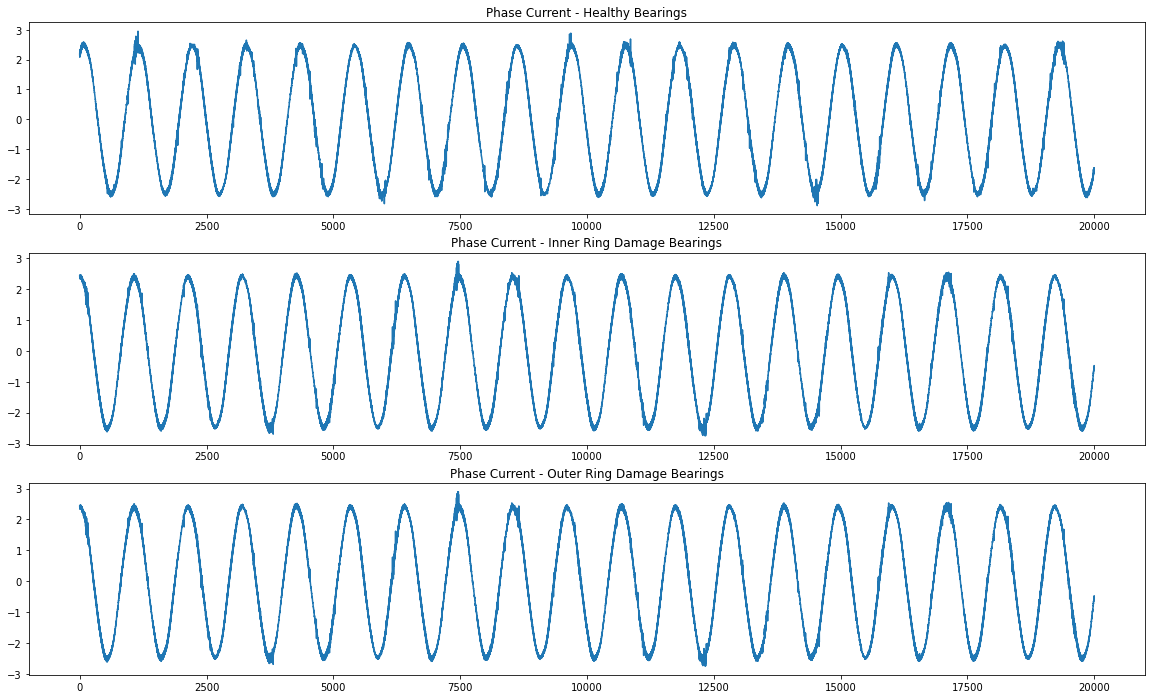

In [53]:
# Plotting the sample current for comparing the Healthy, Inner ring damaged and Outer ring damaged Bearings.

healthy_data = healthy_data.rename(columns = {'phase_current_1':'healthy_phase_current'})
ird_data = ird_data.rename(columns = {'phase_current_1':'ird_phase_current'})
ord_data = ord_data.rename(columns = {'phase_current_1':'ord_phase_current'})

phase_current_data = pd.concat([healthy_data['healthy_phase_current'],ird_data['ird_phase_current'],
                                ord_data['ord_phase_current']], axis = 1)

fig, axs = plt.subplots(3, figsize=(20, 12))
axs[0].plot(phase_current_data['healthy_phase_current'][0:20000])
axs[1].plot(phase_current_data['ird_phase_current'][0:20000])
axs[2].plot(phase_current_data['ord_phase_current'][0:20000])
axs[0].title.set_text('Phase Current - Healthy Bearings')
axs[1].title.set_text('Phase Current - Inner Ring Damage Bearings')
axs[2].title.set_text('Phase Current - Outer Ring Damage Bearings')

### EDA (Healthy vs Real Damage vs Articial Damage Bearings)

The sample visualizations in this notebook are plotted using the below matlab files

1. Healthy Bearing : N09_M07_F10_K001_1.mat
2. Real Damage Bearing : N09_M07_F10_KA04_1.mat
3. Artificial Damage Bearing : N09_M07_F10_KA01_1.mat


In [55]:
healthy_bearing  =  eda_metrics_data('your_healthy_bearing_matlab_file_path')
real_damage_bearing  =  eda_metrics_data('your_real_damage_bearing_matlab_file_path')
artificial_damage  =  eda_metrics_data('your_artificial_damage_bearing_matlab_file_path')

In [56]:
healthy_bearing = healthy_bearing.rename(columns = {'vibration_1':'healthy_vibrations'})
real_damage_bearing = real_damage_bearing.rename(columns = {'vibration_1':'real_damage_vibrations'})
artificial_damage = artificial_damage.rename(columns = {'vibration_1':'artificial_damage_vibrations'})

<AxesSubplot:>

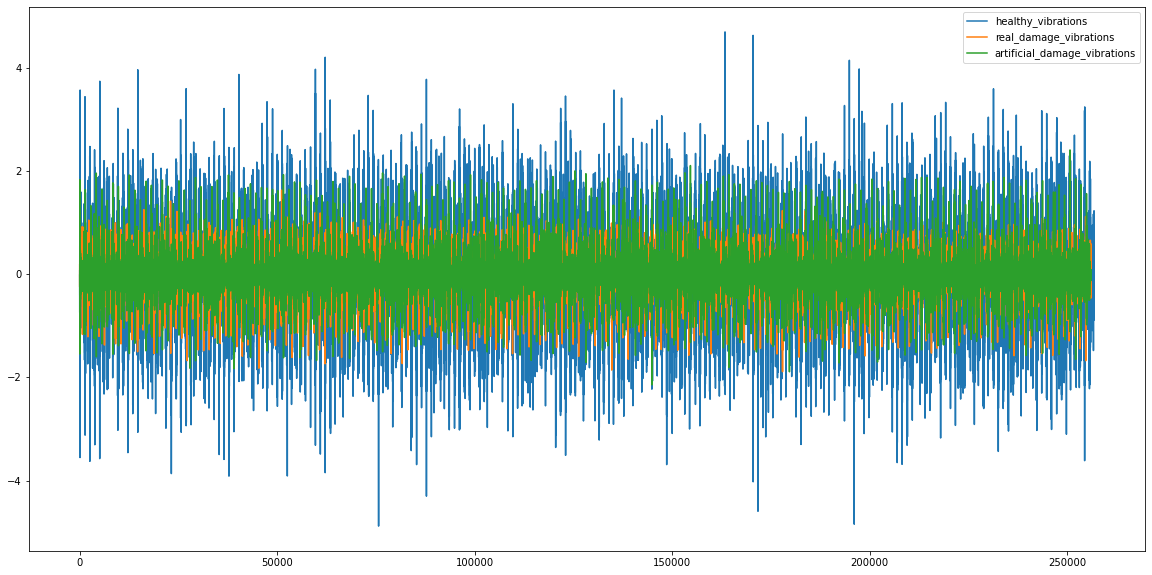

In [57]:
vibrations_data = pd.concat([healthy_bearing['healthy_vibrations'],real_damage_bearing['real_damage_vibrations'],artificial_damage['artificial_damage_vibrations']], axis = 1)
vibrations_data.plot()

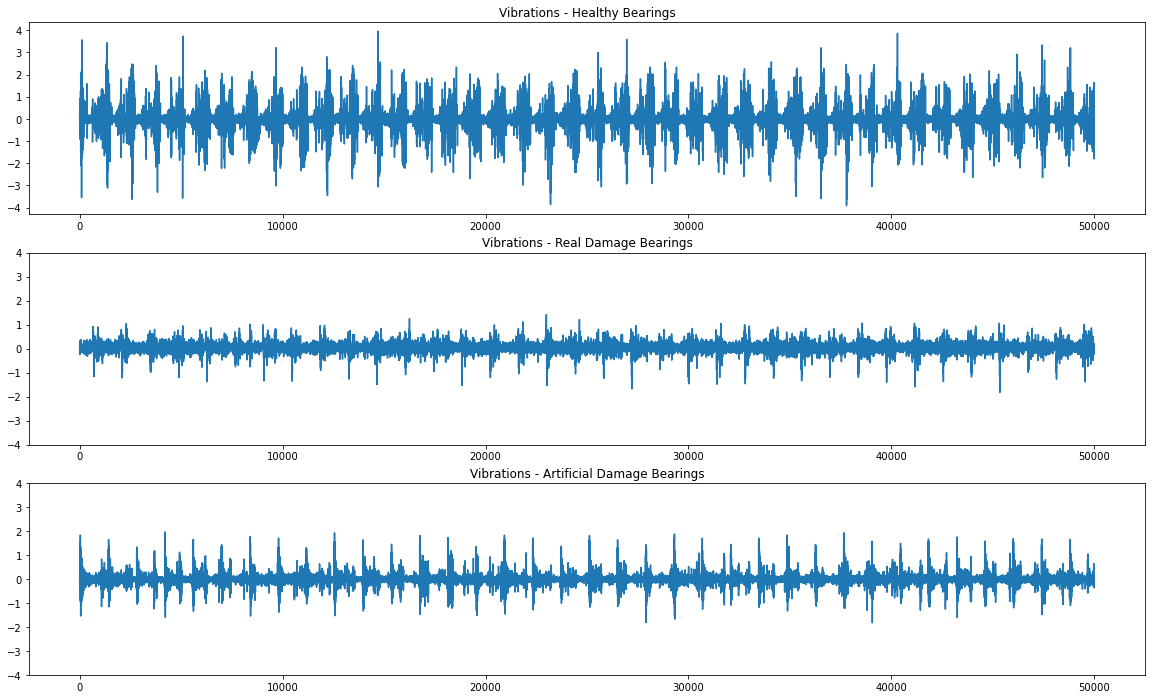

In [58]:
fig, axs = plt.subplots(3, figsize=(20, 12))
axs[0].plot(vibrations_data['healthy_vibrations'][0:50000])
axs[1].plot(vibrations_data['real_damage_vibrations'][0:50000])
axs[1].set_ylim([-4, 4])
axs[2].plot(vibrations_data['artificial_damage_vibrations'][0:50000])
axs[2].set_ylim([-4, 4])
axs[0].title.set_text('Vibrations - Healthy Bearings')
axs[1].title.set_text('Vibrations - Real Damage Bearings')
axs[2].title.set_text('Vibrations - Artificial Damage Bearings')

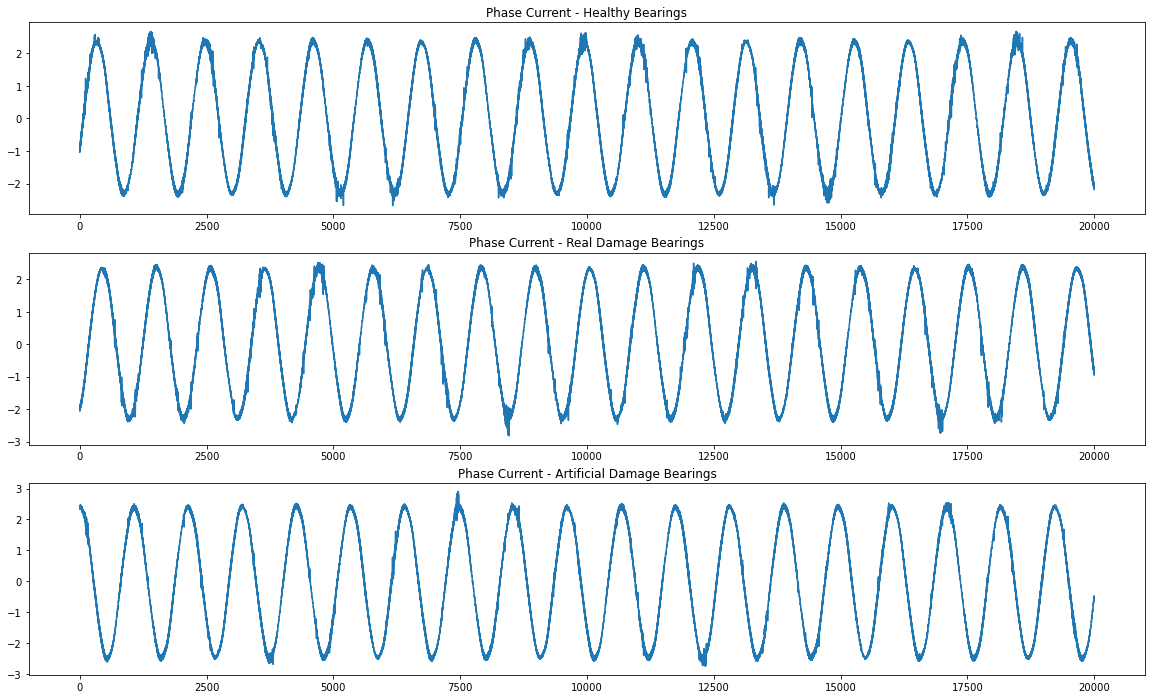

In [59]:
healthy_bearing = healthy_bearing.rename(columns = {'phase_current_1':'healthy_phase_current'})
real_damage_bearing = real_damage_bearing.rename(columns = {'phase_current_1':'real_damage_phase_current'})
artificial_damage = artificial_damage.rename(columns = {'phase_current_1':'artificial_damage_phase_current'})

phase_current_data = pd.concat([healthy_bearing['healthy_phase_current'],real_damage_bearing['real_damage_phase_current'],
                                artificial_damage['artificial_damage_phase_current']], axis = 1)

fig, axs = plt.subplots(3, figsize=(20, 12))
axs[0].plot(phase_current_data['healthy_phase_current'][0:20000])
axs[1].plot(phase_current_data['real_damage_phase_current'][0:20000])
axs[2].plot(phase_current_data['artificial_damage_phase_current'][0:20000])
axs[0].title.set_text('Phase Current - Healthy Bearings')
axs[1].title.set_text('Phase Current - Real Damage Bearings')
axs[2].title.set_text('Phase Current - Artificial Damage Bearings')

### Real Damage (Extent of Damage Analysis)
The analysis is performed to understand the effect of the extent of damage in the variations of the vibrations. 

The sample visualizations in this notebook are plotted using the below matlab files
1. Extent of Damage - 1st Level : N09_M07_F10_KI14_1.mat
2. Extent of Damage - 2nd Level : N09_M07_F10_KI16_1.mat
3. Extent of Damage - 3rd Level : N09_M07_F10_KI18_1.mat

In [63]:
bearing_damage_1  =  eda_metrics_data('your_1st_level_damaged_bearing_matlab_file_path')
bearing_damage_2  =  eda_metrics_data('your_2nd_level_damaged_bearing_matlab_file_path')
bearing_damage_3  =  eda_metrics_data('your_3rd_level_damaged_bearing_matlab_file_path')

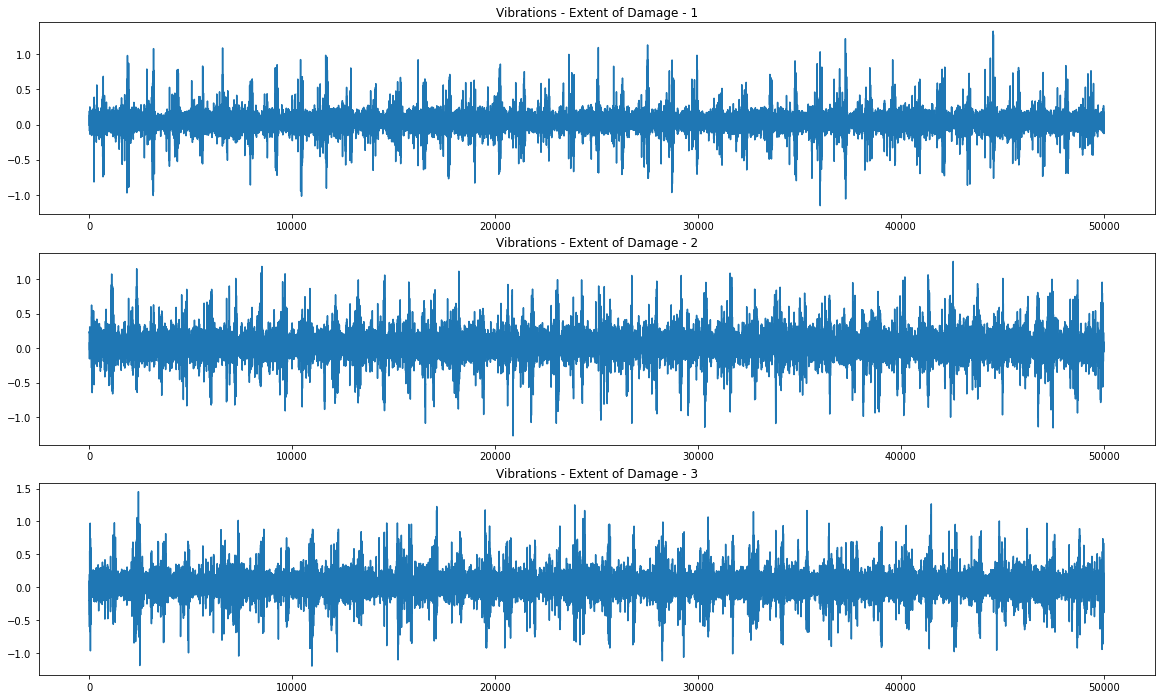

In [64]:
bearing_damage_1 = bearing_damage_1.rename(columns = {'vibration_1':'bearing_damage_1_vibrations'})
bearing_damage_2 = bearing_damage_2.rename(columns = {'vibration_1':'bearing_damage_2_vibrations'})
bearing_damage_3 = bearing_damage_3.rename(columns = {'vibration_1':'bearing_damage_3_vibrations'})

bearing_damage_data = pd.concat([bearing_damage_1['bearing_damage_1_vibrations'],
                                 bearing_damage_2['bearing_damage_2_vibrations'],
                                 bearing_damage_3['bearing_damage_3_vibrations']], 
                                 axis = 1)

fig, axs = plt.subplots(3, figsize=(20, 12))
axs[0].plot(bearing_damage_data['bearing_damage_1_vibrations'][0:50000])
axs[1].plot(bearing_damage_data['bearing_damage_2_vibrations'][0:50000])
axs[2].plot(bearing_damage_data['bearing_damage_3_vibrations'][0:50000])
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')
axs[2].title.set_text('Vibrations - Extent of Damage - 3')


### Artificial Damage - Inner Ring Damage
The analysis is performed to understand the effect of the artificially created inner ring damage in the variations of the vibrations based on its extent of damage. 

The sample visualizations in this notebook are plotted using the below matlab files
1. Extent of Damage - 1st Level : N09_M07_F10_KI03_1.mat
2. Extent of Damage - 2nd Level : N09_M07_F10_KI05_1.mat


In [66]:
bearing_ad_ir_1  =  eda_metrics_data('your_1st_level_damaged_bearing_matlab_file_path')
bearing_ad_ir_2  =  eda_metrics_data('your_2nd_level_damaged_bearing_matlab_file_path')

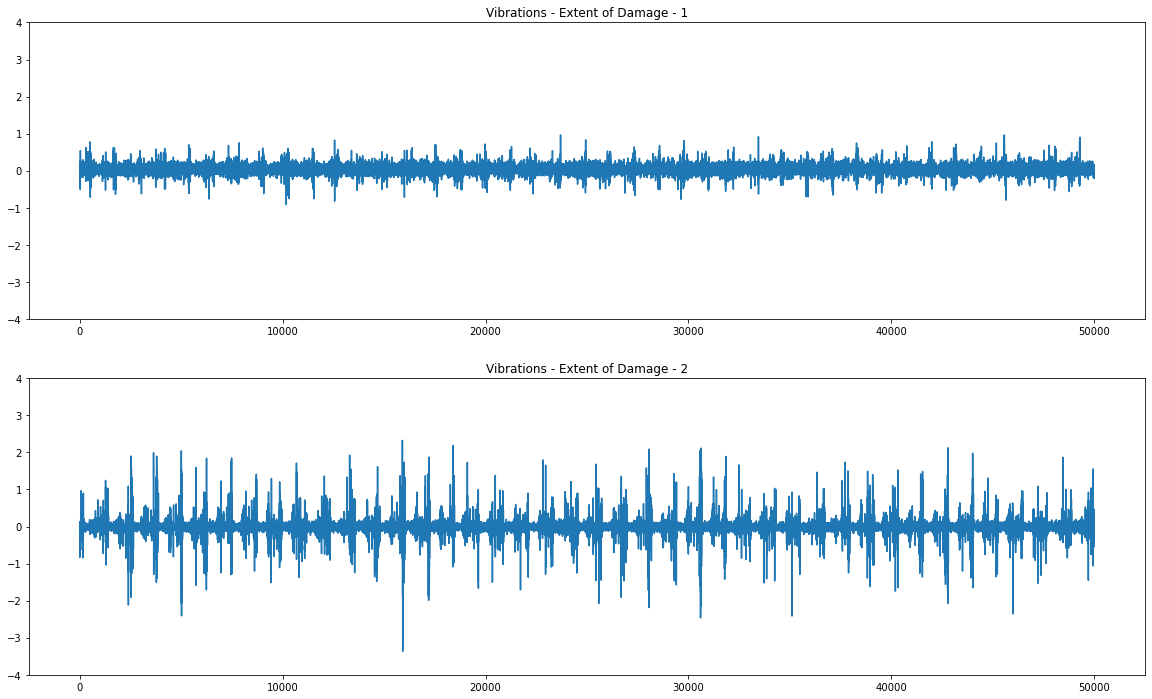

In [67]:
bearing_ad_ir_1 = bearing_ad_ir_1.rename(columns = {'vibration_1':'bearing_ad_ir_1_vibrations'})
bearing_ad_ir_2 = bearing_ad_ir_2.rename(columns = {'vibration_1':'bearing_ad_ir_2_vibrations'})

bearing_ad_ir_data = pd.concat([bearing_ad_ir_1['bearing_ad_ir_1_vibrations'],
                                 bearing_ad_ir_2['bearing_ad_ir_2_vibrations']],
                                 axis = 1)

fig, axs = plt.subplots(2, figsize=(20, 12))
plt.setp(axs, ylim=(-4,4))
axs[0].plot(bearing_ad_ir_data['bearing_ad_ir_1_vibrations'][0:50000])
axs[1].plot(bearing_ad_ir_data['bearing_ad_ir_2_vibrations'][0:50000])
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')

### Artificial Damage - Outer Ring Damage
The analysis is performed to understand the effect of the artificially created outer ring damage in the variations of the vibrations based on its extent of damage. 

The sample visualizations in this notebook are plotted using the below matlab files
1. Extent of Damage - 1st Level : N09_M07_F10_KA05_1.mat
2. Extent of Damage - 2nd Level : N09_M07_F10_KA03_1.mat


In [71]:
bearing_ad_or_1  =  eda_metrics_data(your_1st_level_damaged_bearing_matlab_file_path)
bearing_ad_or_2  =  eda_metrics_data(your_2nd_level_damaged_bearing_matlab_file_path)

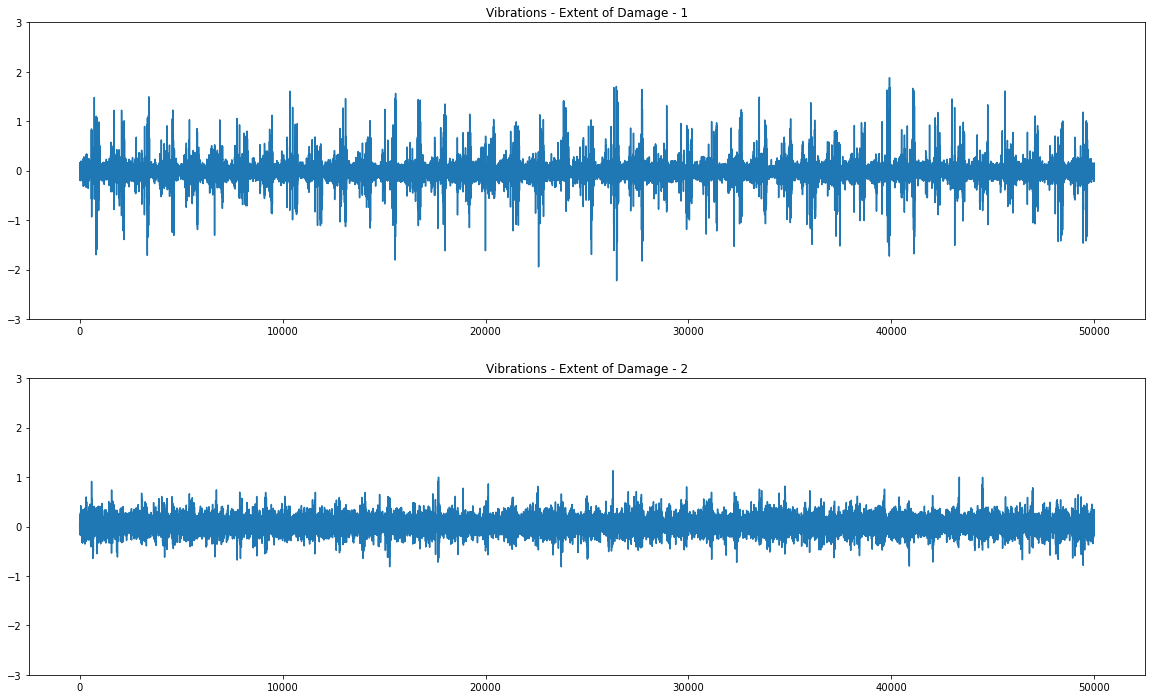

In [72]:
bearing_ad_or_1 = bearing_ad_or_1.rename(columns = {'vibration_1':'bearing_ad_or_1_vibrations'})
bearing_ad_or_2 = bearing_ad_or_2.rename(columns = {'vibration_1':'bearing_ad_or_2_vibrations'})

bearing_ad_or_data = pd.concat([bearing_ad_or_1['bearing_ad_or_1_vibrations'],
                                bearing_ad_or_2['bearing_ad_or_2_vibrations']],
                                axis = 1)

fig, axs = plt.subplots(2, figsize=(20, 12))
plt.setp(axs, ylim=(-3,3))
axs[0].plot(bearing_ad_or_data['bearing_ad_or_1_vibrations'][0:50000])
axs[1].plot(bearing_ad_or_data['bearing_ad_or_2_vibrations'][0:50000])
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')

### Feature Engineering

Merging Damage information with the Bearing Vibration and Current Signals

In [10]:
damage_info = pd.read_csv(Damage_Info_csv)

def data_prep(matlab_file_path): 
    
    """
    This function is to create a consolidated dataframe for the EDA from reading the matlab files, 
    adding the damage info and operating conditions to it.  
    
    Input -  Matlab file path and Damage Info file created from the reference paper.
    
    Output - Consolidated dataframe with all the signal metrics, damage info and 
    operational conditions for further analysis.
    
    """
    
    uncleaned_data = data_intake(matlab_file_path)
    cleaned_data = data_flatten(uncleaned_data)
    consolidated_cleaned_data = data_merge(cleaned_data)
    
    temp = consolidated_cleaned_data[['Name','Data_y']].T.reset_index()
    del(temp['index'])
    temp.columns = temp.iloc[0]
    temp = temp.iloc[1:,:6]
    
    for col in temp.columns:
        temp[col][1] = temp[col][1][:1000]
    
    matlab_file_name = os.path.basename(matlab_file_path)
    temp['Bearing_Code'] = matlab_file_name[matlab_file_name.rfind('K'):matlab_file_name.rfind('_')]
    temp['Rotational_speed'] = int(matlab_file_name[matlab_file_name.rfind('N')+1:matlab_file_name.rfind('_M')])*100
    temp['Load_Torque'] = int(matlab_file_name[matlab_file_name.rfind('M')+1:matlab_file_name.rfind('_F')])/10
    temp['Radial_Force'] = int(matlab_file_name[matlab_file_name.rfind('F')+1:matlab_file_name.rfind('_K')])*100

    return temp


In [12]:
data = pd.DataFrame()

for name in sorted(glob.glob(Your_matlab_files_folder)):
    for file in sorted(glob.glob(name+'/*.mat')):
        data = data.append(data_prep(file))
        
    
data = data.groupby(['Bearing_Code','Rotational_speed','Load_Torque','Radial_Force']) \
           .agg(lambda x: list(x))

for i in range(0,len(data)):
    for col in data.columns:
        data[col][i] = [item for items in data[col][i] for item in items]

    
data = data.reset_index()

final_data = damage_info.merge(data, on = 'Bearing_Code',how = 'right')

In [94]:
def min_col(data,col):
    """
    This function is to calculate the minium value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated minimum value
    """
    
    return data[col].apply(lambda x: min(x))

def peak_value(data,col):
    """
    This function is to calculate the maximum value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated maximum value
    """
    
    return data[col].apply(lambda x: max(np.abs(x)))

def avg_col(data,col):
    """
    This function is to calculate the average value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated average value
    """
    return data[col].apply(lambda x: np.mean(x))

def std_dev(data,col):
    """
    This function is to calculate the standard deviation value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated standard deviation value
    """
    
    return data[col].apply(lambda x: np.std(x))


In [95]:
def root_mean_square(data,col):
    """
    This function is to calculate the Root Mean Square value (RMS) of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated RMS value
    """
    
    return data[col].apply(lambda x: np.sqrt(sum(i*i for i in x)/len(x)))

def crest_factor(data,col):
    """
    This function is to calculate the Crest factor value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated crest factor value
    """
        
    return peak_value(data,col) / root_mean_square(data,col) 

def kurtosis(data,col):
    """
    This function is to calculate the kurtosis value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated kurtosis value
    """
        
    return data[col].apply(lambda x: scipy.stats.kurtosis(x, fisher=False))

def clearance_factor(data,col):
    """
    This function is to calculate the clearance factor value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated clearance factor value
    """
    
    return peak_value(data,col) / data[col].apply(lambda x: np.square(sum(np.sqrt(np.abs(x)))/len(x)))

In [96]:
def impulse_factor(data,col):
    """
    This function is to calculate the impulse factor value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated impulse factor value
    """
    
    return peak_value(data,col) /data[col].apply(lambda x: sum(np.abs(x))/len(x))   

def shape_factor(data,col):
    """
    This function is to calculate the shape factor value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated shape factor value
    """
    
    return root_mean_square(data,col) /data[col].apply(lambda x: sum(np.abs(x))/len(x))   

def peak_to_peak(data,col):
    """
    This function is to calculate the gap between the maximum value and the minimum value of the signal  
    
    Input -  Dataframe and the signal name 
    Output - Calculated peak to peak value
    """
    
    return data[col].apply(lambda x: max(x)) -  data[col].apply(lambda x: min(x))


In [15]:
for col in data.columns[4:]:
    final_data['min_'+col] = min_col(final_data,col)
    final_data['max_'+col] = peak_value(final_data,col)
    final_data['avg_'+col] = avg_col(final_data,col)
    final_data['std_'+col] = std_dev(final_data,col)
    final_data['rms_'+col] = root_mean_square(final_data,col)
    final_data['crest_factor_'+col] = crest_factor(final_data,col)
    final_data['kurtosis_'+col] = kurtosis(final_data,col)
    final_data['clf_factor_'+col] = clearance_factor(final_data,col)
    final_data['impulse_factor_'+col] = impulse_factor(final_data,col)   
    final_data['shape_factor_'+col] = shape_factor(final_data,col)  
    final_data['pp_'+col] = peak_to_peak(final_data,col)

In [17]:
#Expanding the metrics list to form a complete datframe

final_data = final_data.explode(['force', 'speed', 'torque', 'phase_current_1', 'phase_current_2','vibration_1']) 

### Vibrations Distribution Analysis

#### Operating Conditions 
1. Rotational Speed = 900
2. Load Torque = 0.7
3. Radial Force = 1000

In [ ]:
final_data.iloc[[108,120,112],:]

,Bearing_Code,Component,Extent_of_Damage,Damage_Method,Damage_Type,Rotational_speed,Load_Torque,Radial_Force,force,speed,...,avg_phase_current_2,std_phase_current_2,min_vibration_1,max_vibration_1,avg_vibration_1,std_vibration_1,min_temp_2_bearing_module,max_temp_2_bearing_module,avg_temp_2_bearing_module,std_temp_2_bearing_module
108,KI14,inner_ring,1.0,fatigue_pitting,Real_Damage,900,0.7,1000,"[926.9576165505946, 927.2627923316428, 932.755...","[898.3182764764367, 898.3181414755101, 898.318...",...,0.117042,1.722036,-1.541138,1.647949,0.042412,0.113058,47.726440,51.577759,49.412039,1.125485
120,KI18,inner_ring,2.0,fatigue_pitting,Real_Damage,900,0.7,1000,"[953.8130852828467, 955.6441399691365, 955.644...","[899.3028806328248, 899.3029370770073, 899.302...",...,0.041334,1.682632,-2.017212,2.001953,0.040684,0.160614,28.475952,29.507446,28.919159,0.263781
112,KI16,inner_ring,3.0,fatigue_pitting,Real_Damage,900,0.7,1000,"[1004.1670891558193, 1004.1670891558193, 1005....","[900.037154717785, 900.0346075622703, 900.0320...",...,-0.005217,1.700775,-2.084351,1.779175,0.040572,0.166834,40.103149,41.912842,40.896483,0.505169


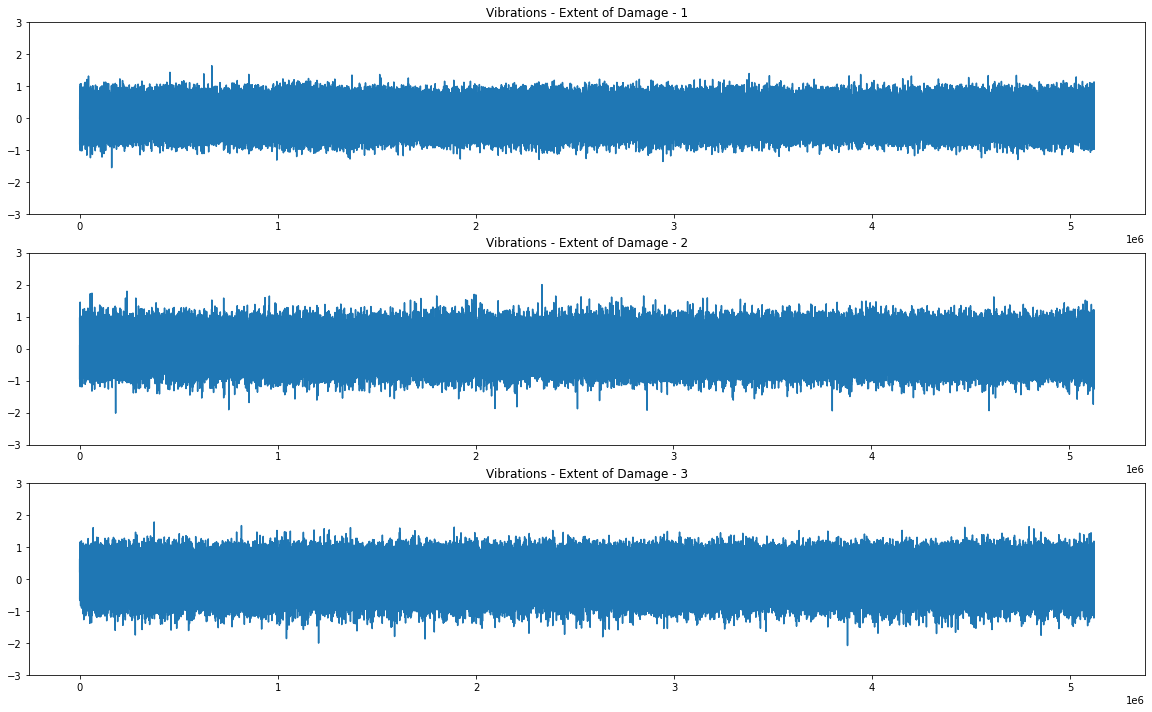

In [ ]:
fig, axs = plt.subplots(3, figsize=(20, 12))
plt.setp(axs, ylim=(-3,3))
axs[0].plot(final_data.iloc[108,:]['vibration_1'])
axs[1].plot(final_data.iloc[120,:]['vibration_1'])
axs[2].plot(final_data.iloc[112,:]['vibration_1'])
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')
axs[2].title.set_text('Vibrations - Extent of Damage - 3')

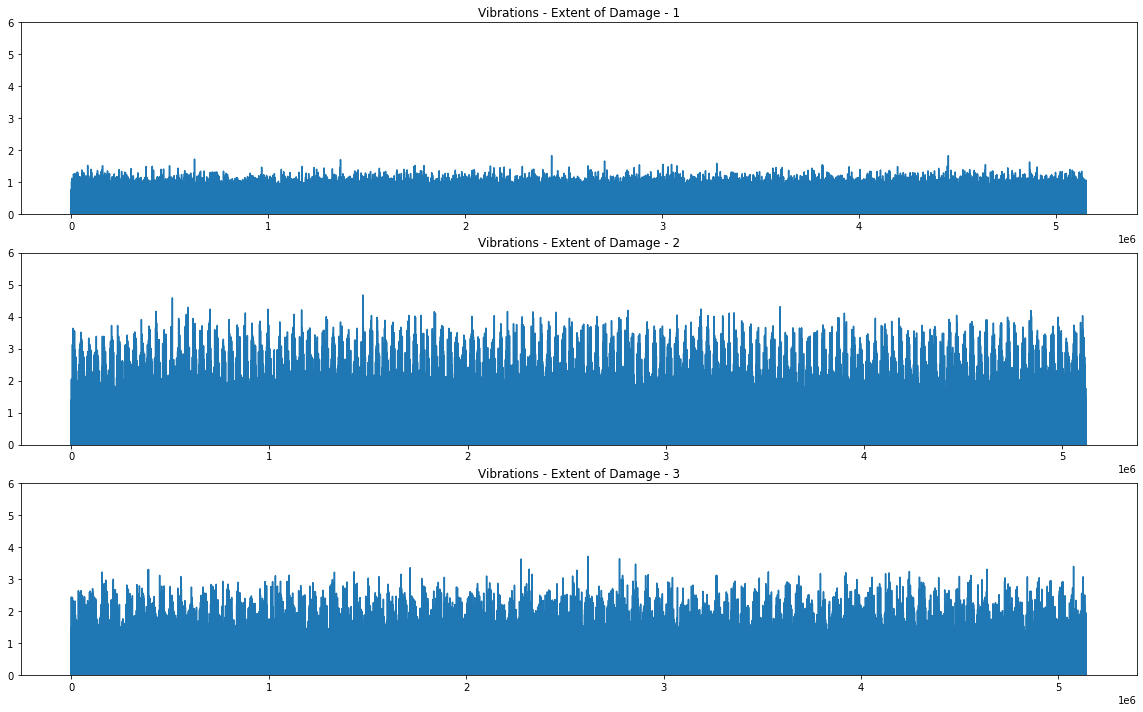

In [ ]:
fig, axs = plt.subplots(3, figsize=(20, 12))
plt.setp(axs, ylim=(0,6))
axs[0].plot(np.abs(final_data.iloc[111,:]['vibration_1']))
axs[1].plot(np.abs(final_data.iloc[123,:]['vibration_1']))
axs[2].plot(np.abs(final_data.iloc[115,:]['vibration_1']))
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')
axs[2].title.set_text('Vibrations - Extent of Damage - 3')

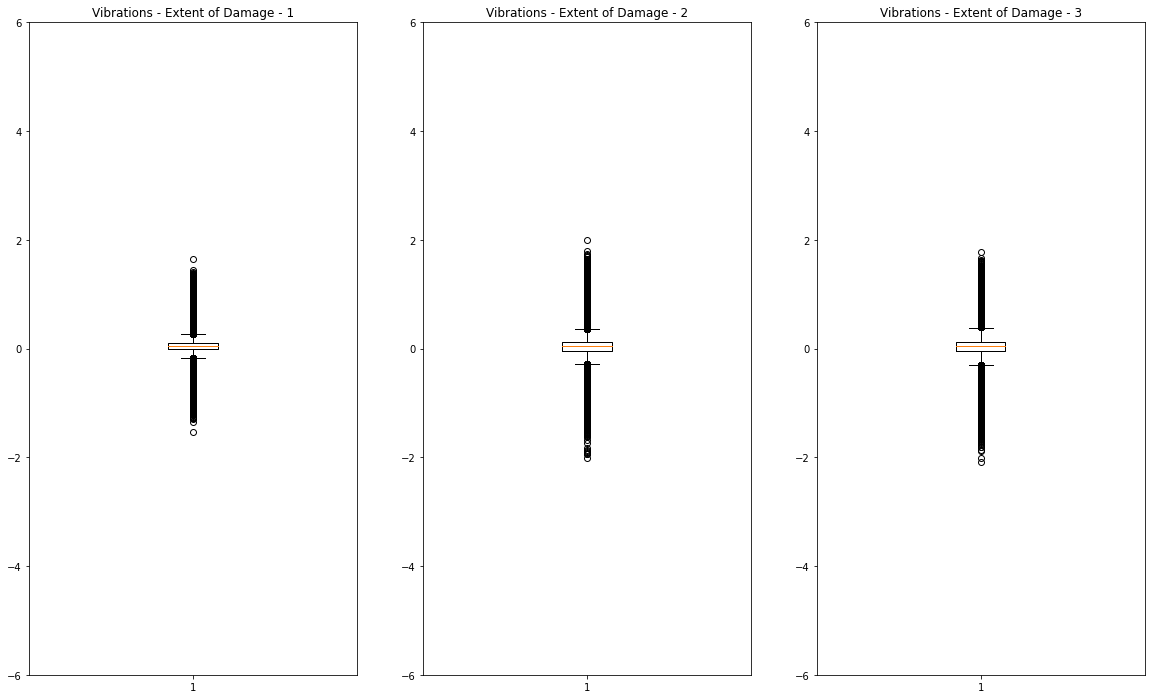

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20, 12))
plt.setp(axs, ylim=(-6,6))
axs[0].boxplot(final_data.iloc[108,:]['vibration_1'])
axs[1].boxplot(final_data.iloc[120,:]['vibration_1'])
axs[2].boxplot(final_data.iloc[112,:]['vibration_1'])
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')
axs[2].title.set_text('Vibrations - Extent of Damage - 3')

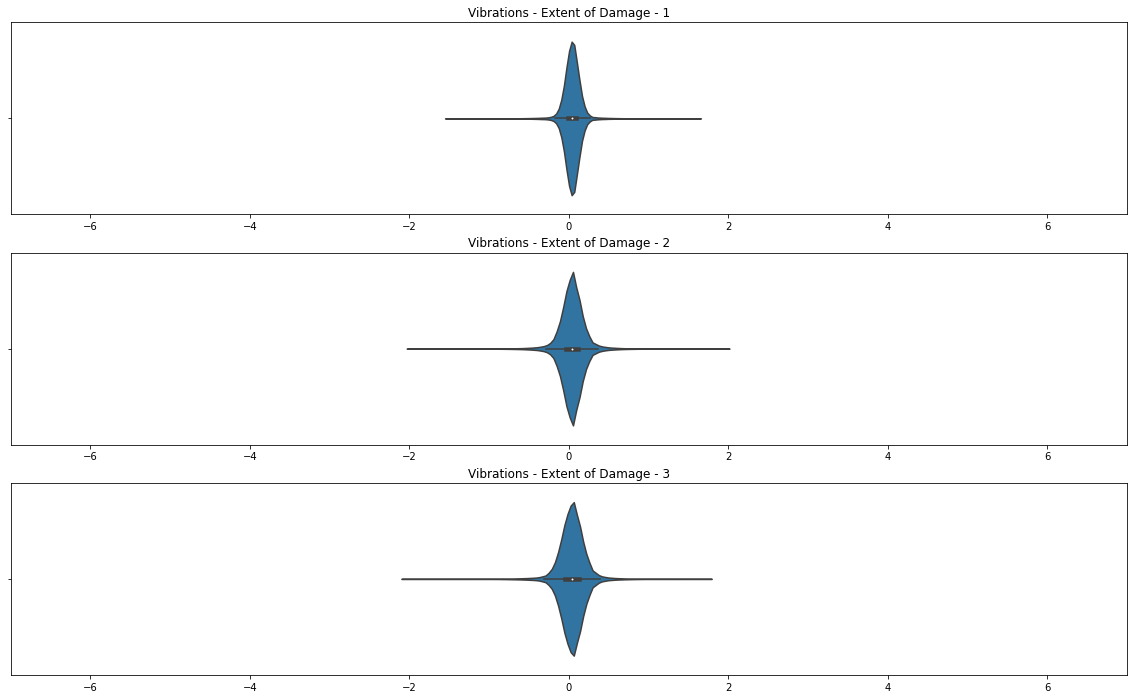

In [ ]:
fig, axs = plt.subplots(3, figsize=(20, 12))
plt.setp(axs, xlim=(-7,7))
sns.violinplot(x=final_data.iloc[108,:]['vibration_1'], ax = axs[0])
sns.violinplot(x=final_data.iloc[120,:]['vibration_1'], ax = axs[1])
sns.violinplot(x=final_data.iloc[112,:]['vibration_1'], ax = axs[2])
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')
axs[2].title.set_text('Vibrations - Extent of Damage - 3')

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

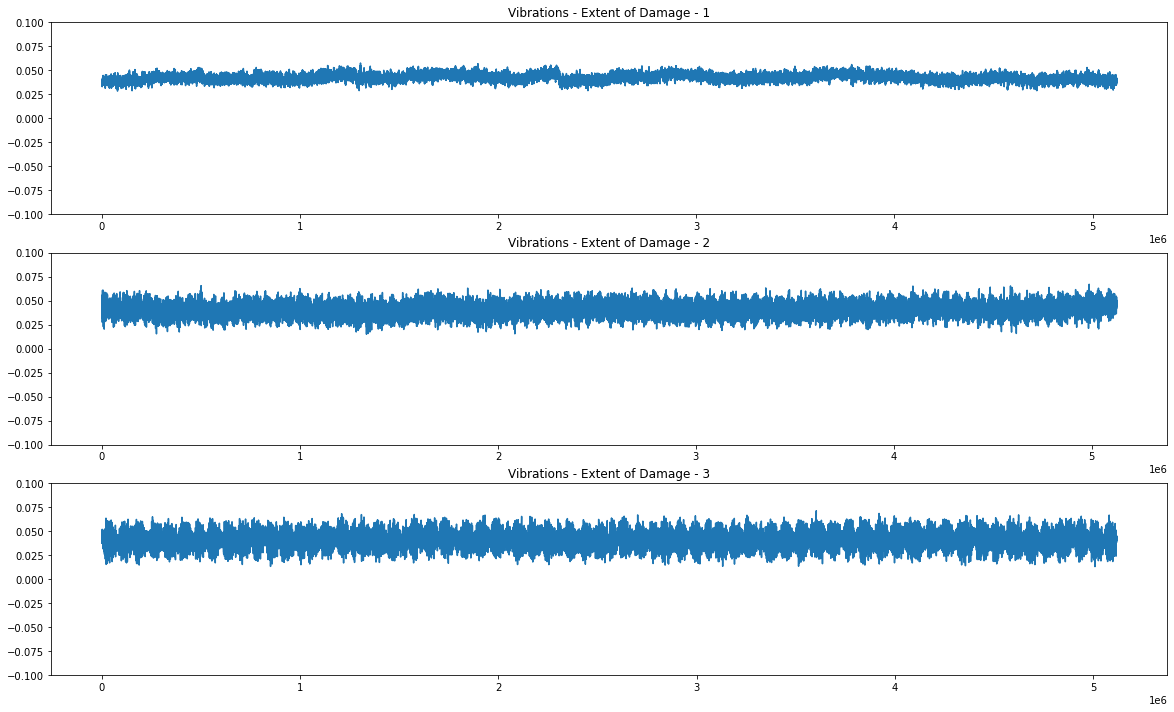

In [ ]:
fig, axs = plt.subplots(3, figsize=(20, 12))
plt.setp(axs, ylim=(-0.1,0.1))
axs[0].plot(moving_average(final_data.iloc[108,:]['vibration_1'], 1000))
axs[1].plot(moving_average(final_data.iloc[120,:]['vibration_1'], 1000))
axs[2].plot(moving_average(final_data.iloc[112,:]['vibration_1'], 1000))
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')
axs[2].title.set_text('Vibrations - Extent of Damage - 3')

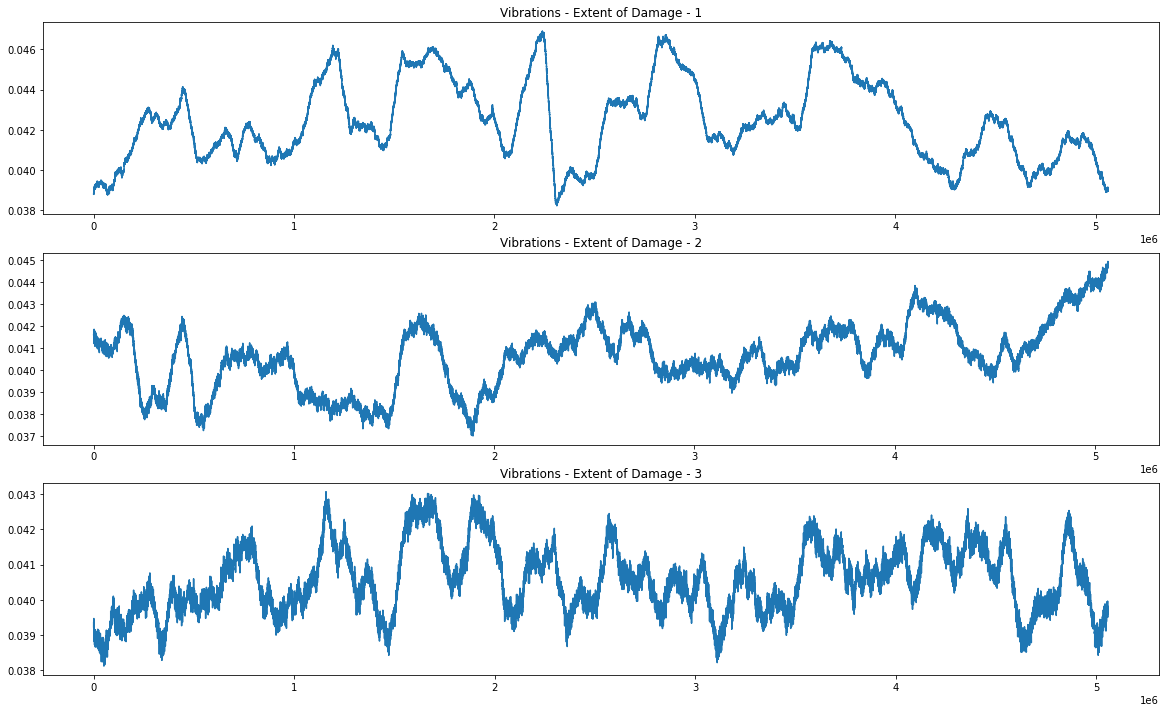

In [ ]:
fig, axs = plt.subplots(3, figsize=(20, 12))
# plt.setp(axs, ylim=(-0.1,0.1))
axs[0].plot(moving_average(final_data.iloc[108,:]['vibration_1'], 60000))
axs[1].plot(moving_average(final_data.iloc[120,:]['vibration_1'], 60000))
axs[2].plot(moving_average(final_data.iloc[112,:]['vibration_1'], 60000))
axs[0].title.set_text('Vibrations - Extent of Damage - 1')
axs[1].title.set_text('Vibrations - Extent of Damage - 2')
axs[2].title.set_text('Vibrations - Extent of Damage - 3')

### RandomForest Classifier Model

In [33]:
for col in final_data.columns[:8]:
    final_data[col] = final_data[col].astype('category')

In [34]:
categories = np.array([0,1,2,3])
final_data['Extent_of_Damage']= pd.Categorical(final_data['Extent_of_Damage'], categories=categories, ordered=True)
final_data['Extent_of_Damage'] = final_data['Extent_of_Damage'].fillna(0)
final_data = final_data.reset_index()
del(final_data['index'])

#### Random Forest model built using the phase current and Vibrational Signal alone (Version 1)

In [63]:
X = final_data[['Rotational_speed', 'Load_Torque', 'Radial_Force',
                'phase_current_1', 'phase_current_2',
                'vibration_1']]
y = final_data["Extent_of_Damage"]

In [56]:
X_train.head()

,Rotational_speed,Load_Torque,Radial_Force,force,speed,torque,phase_current_1,phase_current_2,vibration_1
735995,900,0.7,1000,1062.760839,899.685566,1.235852,-0.267247,-1.943742,-0.021362
464740,1500,0.7,1000,936.418066,1499.726025,1.088055,-2.153132,2.083565,1.016235
1068755,1500,0.1,1000,1136.918554,1501.677162,0.631319,0.148777,-1.241185,-0.601196
2006581,900,0.7,1000,1104.569921,900.106254,1.292893,2.364588,-1.650321,-0.082397
609488,1500,0.7,400,421.891699,1499.273422,1.335325,-2.445864,1.518075,0.003052


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=20)

clf_v2 = RandomForestClassifier(n_estimators = 100)  
clf_v2.fit(X_train, y_train)
y_pred_v2 = clf_v2.predict(X_test)

In [65]:
print("Model Accuracy: ", round(accuracy_score(y_test, y_pred_v2)*100,2),"%")

Model Accuracy:  42.82 %


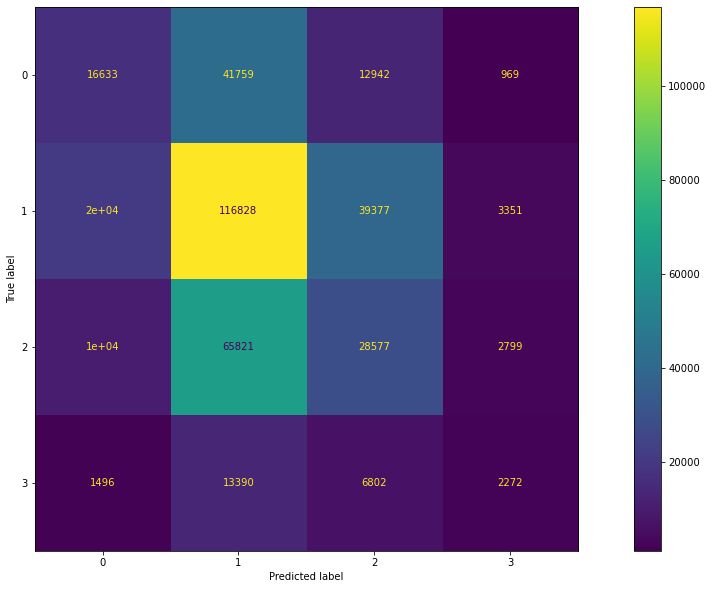

In [66]:
cm = confusion_matrix(y_test, y_pred_v2, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

<AxesSubplot:>

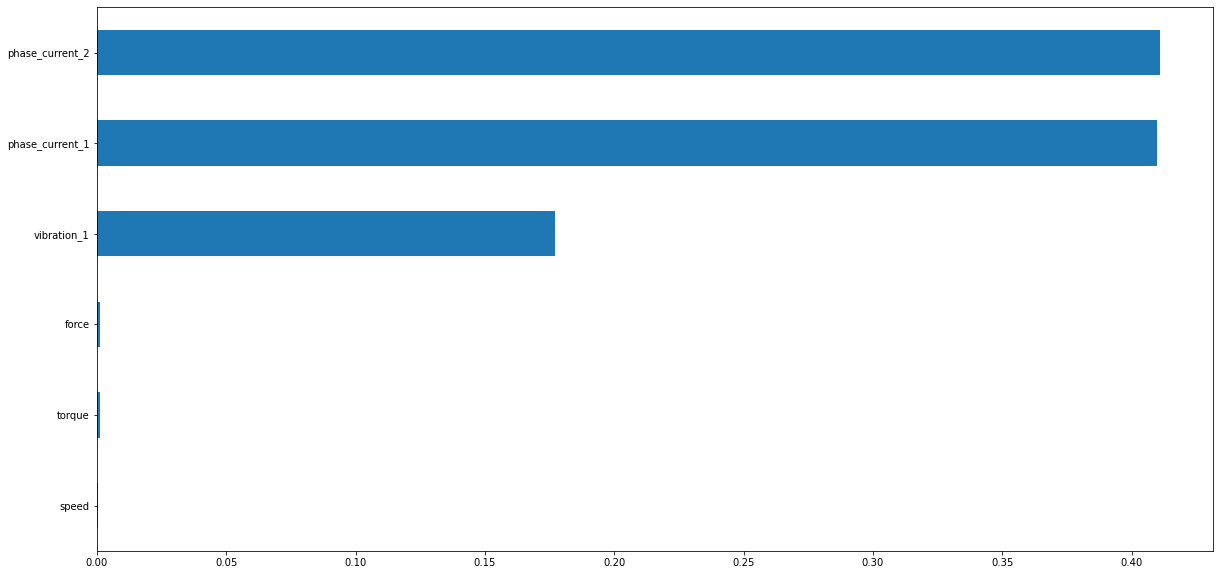

In [90]:
feat_importances = pd.Series(clf_v2.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values(ascending = True).plot(kind='barh')

#### Random Forest model built using the phase current and Vibrational Signal alone (Version 2)

In [ ]:
X = final_data[['force', 'speed', 'torque',
                'phase_current_1', 'phase_current_2',
                'vibration_1']]

y = final_data["Extent_of_Damage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=20)

clf_v3 = RandomForestClassifier(n_estimators = 100)  
clf_v3.fit(X_train, y_train)
y_pred_v3 = clf_v3.predict(X_test)

Model Accuracy:  76.2 %


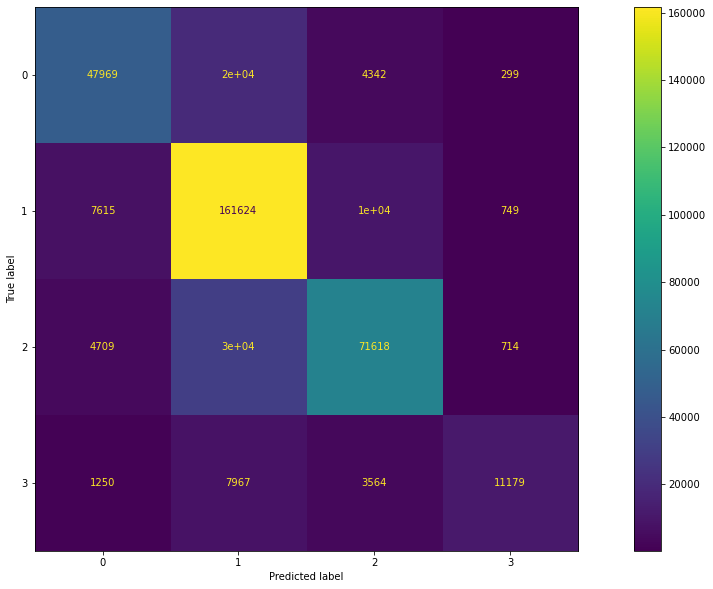

In [91]:
print("Model Accuracy: ", round(accuracy_score(y_test, y_pred_v3)*100,2),"%")

cm = confusion_matrix(y_test, y_pred_v3, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_v3.classes_)
disp.plot()
plt.show()

<AxesSubplot:>

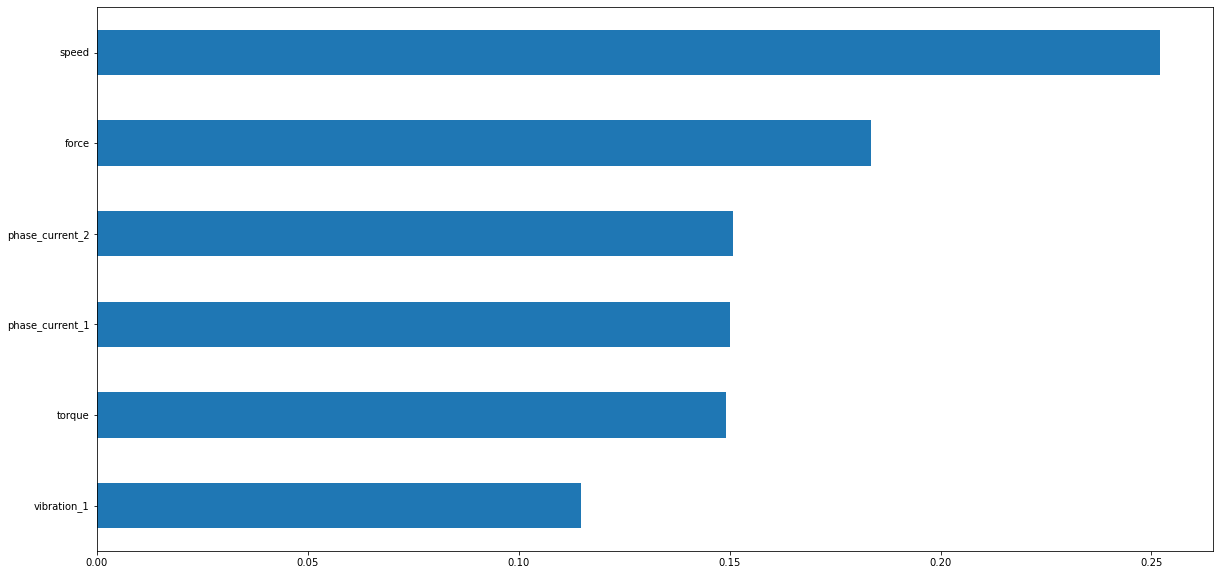

In [92]:
feat_importances = pd.Series(clf_v3.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values(ascending = True).plot(kind='barh')

#### Random Forest model with all the calculated metrics of the metrics

In [ ]:
X = final_data.drop(columns=['Bearing_Code', 'Component', 'Extent_of_Damage', 'Damage_Method',
                             'Damage_Type', 'Rotational_speed', 'Load_Torque', 'Radial_Force',])

y = final_data["Extent_of_Damage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=20)

clf_v4 = RandomForestClassifier(n_estimators = 100)  
clf_v4.fit(X_train, y_train)
y_pred_v4 = clf_v4.predict(X_test)

Model Accuracy:  100.0 %


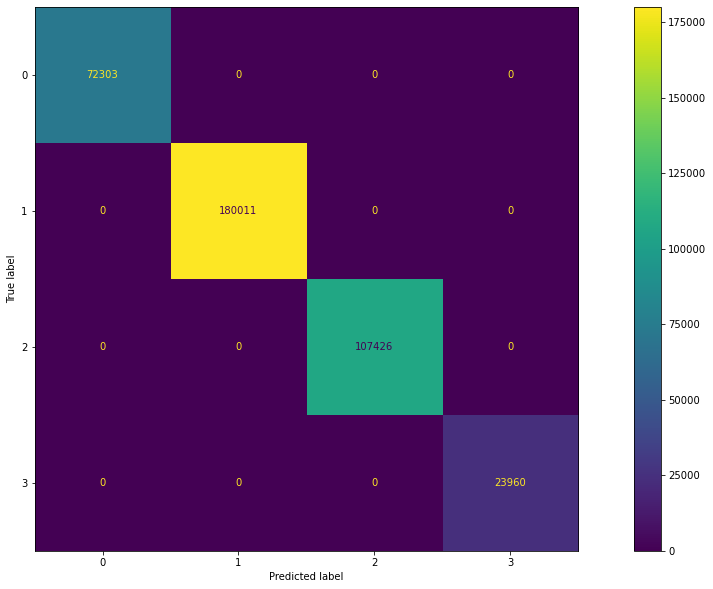

In [98]:
print("Model Accuracy: ", round(accuracy_score(y_test, y_pred_v4)*100,2),"%")

cm = confusion_matrix(y_test, y_pred_v4, labels=clf_v4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_v4.classes_)
disp.plot()
plt.show()

<AxesSubplot:>

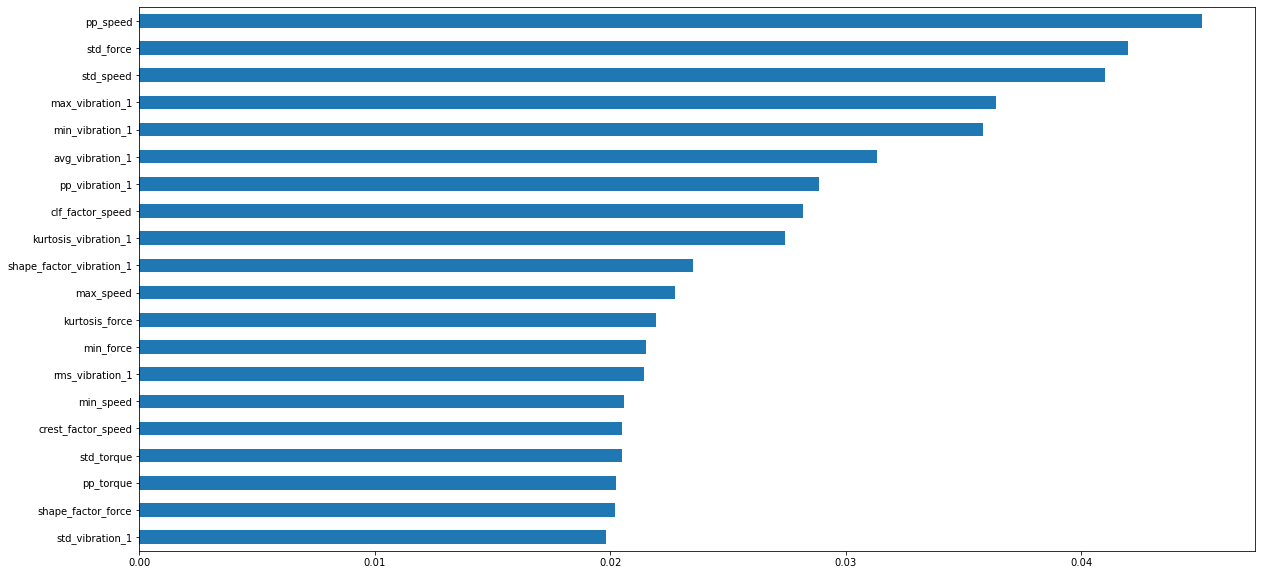

In [88]:
feat_importances = pd.Series(clf_v4.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values(ascending = True).plot(kind='barh')

### SVM Classifier

In [26]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

svm_y_pred = svm_clf.predict(X_test)

In [27]:
print("SVM Classifier Model Accuracy: ", round(accuracy_score(y_test, svm_y_pred)*100,2),"%")

SVM Classifier Model Accuracy:  100.0 %


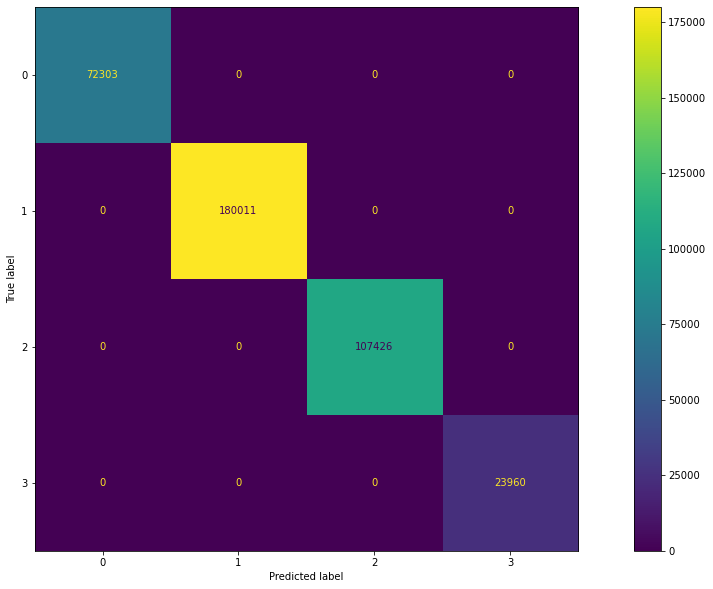

In [28]:
cm = confusion_matrix(y_test, svm_y_pred, labels=svm_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_clf.classes_)
disp.plot()
plt.show()